# Package Dependencies — Graph (Prototype)

Este notebook de prueba carga `Package_Dependencies.csv` desde:

`../reports/csv-reports/Dependencies/Package_Dependencies.csv`

y genera un grafo interactivo de dependencias entre paquetes:

- **Nodo** = paquete (`originPackage` / `destinationPackage`)
- **Arista dirigida** = dependencia (`origin → destination`)
- **Grosor** de la arista = `totalDependencies`
- Se limita a los **N paquetes más “fuertes”** para que se vea legible (por defecto 15).

> Requisitos:
> - `networkx`
> - `plotly`
> - CSVs generados previamente por el pipeline (DependenciesCsv.sh).


In [1]:
import os
from pathlib import Path

import pandas as pd
from neo4j import GraphDatabase
from graphviz import Source  # pip install graphviz  +  brew install graphviz
from IPython.display import display
from pathlib import Path


pd.set_option('future.no_silent_downcasting', True)

# Conexión a Neo4j (usa la env var NEO4J_INITIAL_PASSWORD)
driver = GraphDatabase.driver(
    uri="bolt://localhost:7687",
    auth=("neo4j", os.environ.get("NEO4J_INITIAL_PASSWORD"))
)
driver.verify_connectivity()
print("Conectado a Neo4j.")

def get_cypher_query_from_file(filename: Path) -> str:
    with open(filename) as file:
        return ' '.join(file.readlines())

def query_cypher_to_data_frame(filename: Path, parameters_=None) -> pd.DataFrame:
    if parameters_ is None:
        parameters_ = {}
    records, summary, keys = driver.execute_query(
        get_cypher_query_from_file(filename),
        parameters_=parameters_
    )
    return pd.DataFrame([r.values() for r in records], columns=keys)


Conectado a Neo4j.


In [2]:
def create_directed_unweighted_projection(parameters: dict) -> bool:
    """
    Crea una proyección dirigida para Path Finding usando GDS, minimalista:

      - Nodo: label = dependencies_projection_node (ej: "Package")
      - Relación: DEPENDS_ON
      - Propiedad de peso: dependencies_projection_weight_property (ej: "weight")

    Nombre del grafo en GDS:
      dependencies_projection + '-cleaned'
    """
    base = Path("../cypher/Dependencies_Projection")

    # 0) Verificar que haya al menos una relación DEPENDS_ON con ese label y esa propiedad de peso
    df_check = query_cypher_to_data_frame(base / "Dependencies_0_Check_Projectable.cypher", parameters)
    if df_check.empty:
        print("No hay datos proyectables para la proyección (Check_Projectable vacía).")
        return False

    graph_name = parameters["dependencies_projection"] + "-cleaned"

    # 1) Intentar eliminar una proyección anterior (si existiera)
    try:
        records, summary, keys = driver.execute_query(
            "CALL gds.graph.drop($graph_name, false) YIELD graphName RETURN graphName",
            parameters_={"graph_name": graph_name}
        )
        if records:
            print(f"Proyección previa '{graph_name}' eliminada.")
    except Exception as e:
        # Si no existía, no es error grave
        print(f"[info] No había proyección previa '{graph_name}' que eliminar (o fallo inocuo): {e}")

    # 2) Crear la nueva proyección mínima
    project_cypher = """
    CALL gds.graph.project(
      $graph_name,
      $dependencies_projection_node,
      'DEPENDS_ON',
      { relationshipProperties: [$dependencies_projection_weight_property] }
    )
    YIELD graphName, nodeCount, relationshipCount
    RETURN graphName, nodeCount, relationshipCount
    """

    records, summary, keys = driver.execute_query(
        project_cypher,
        parameters_={
            "graph_name": graph_name,
            "dependencies_projection_node": parameters["dependencies_projection_node"],
            "dependencies_projection_weight_property": parameters["dependencies_projection_weight_property"],
        }
    )

    df_proj = pd.DataFrame([r.values() for r in records], columns=keys)
    print("Proyección creada en GDS:")
    display(df_proj)

    return True


In [3]:
package_path_finding_parameters = {
    "dependencies_projection": "java-package-path-finding-notebook",  # puedes cambiar el nombre si quieres
    "dependencies_projection_node": "Package",                         # label detectado
    "dependencies_projection_weight_property": "weight",               # propiedad detectada
}

is_package_data_available = create_directed_unweighted_projection(package_path_finding_parameters)
print("is_package_data_available:", is_package_data_available)


Proyección previa 'java-package-path-finding-notebook-cleaned' eliminada.
Proyección creada en GDS:


,graphName,nodeCount,relationshipCount
0,java-package-path-finding-notebook-cleaned,6846,42966


is_package_data_available: True


In [4]:
if not is_package_data_available:
    print("[info] No hay datos proyectados para paquetes, revisa la proyección.")
else:
    cypher_path = Path("../cypher/Path_Finding/Path_Finding_6_Longest_paths_contributors_for_graphviz_custom.cypher")
    df_longest = query_cypher_to_data_frame(cypher_path, package_path_finding_parameters)

    print("Filas devueltas:", len(df_longest))
    print("Columnas:", list(df_longest.columns))
    display(df_longest.head())


Filas devueltas: 68
Columnas: ['graphVizDotNotationLine']


,graphVizDotNotationLine
0,"""session"" -> ""logging"" [label=2; penwidth=1.0;..."
1,"""authentication"" -> ""logging"" [label=15; penwi..."
2,"""csrf"" -> ""logging"" [label=4; penwidth=1.0; ];"
3,"""logout"" -> ""logging"" [label=3; penwidth=1.0; ];"
4,"""session"" -> ""logging"" [label=5; penwidth=1.0; ];"


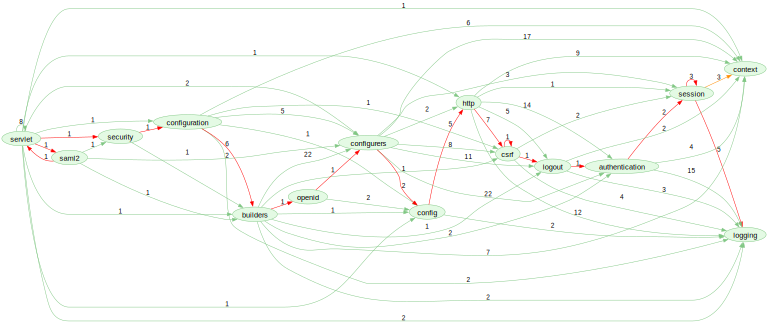

In [21]:
if 'df_longest' not in globals():
    print("[info] df_longest no está definido; ejecuta primero la celda de la query de longest paths.")
elif df_longest.empty:
    print("[info] La query de longest paths no devolvió datos.")
else:

    # El cuerpo del template default.template.gv entre //Begin-Template y //End-Template
    template_body = """
    graph [
        size="8,6!",   // tamaño total del gráfico (en pulgadas)
        dpi=96;
    ];

    rankdir = LR;
    fontname = "Helvetica,Arial,sans-serif";
    fontsize = 14;   // font base del grafo

    node [
        fontname = "Helvetica,Arial,sans-serif";
        fontsize = 16;          // tamaño de fuente de los nombres de los paquetes
        shape = ellipse;        // <-- óvalos en lugar de cajas
        style = filled;
        margin = "0.08,0.04";   // muy poco padding interno
        width = 0.0;            // tamaño según el texto
        height = 0.0;
        fillcolor = "#e4fae4";  // verde MUY suave
        color = "#81c784";      // borde verde un poco más oscuro
    ];

    edge [
        fontname = "Helvetica,Arial,sans-serif";
        fontsize = 14;          // tamaño de fuente de los labels/pesos
        color = "#81c784";      // mismo tono de verde que el borde
    ];

    overlap = false;
    splines = true;

    // aún más compactos:
    nodesep = 0.2;   // distancia horizontal mínima entre nodos
    ranksep = 0.0;   // distancia vertical entre niveles

    // opcional: ayuda a empaquetar un poco más
    pack = true;
    packmode = "graph";
    """.rstrip("\\n")





    col_name = "graphVizDotNotationLine"
    if col_name not in df_longest.columns:
        raise ValueError(f"No se encontró la columna {col_name} en el resultado.")

    # Cada fila es una línea DOT del tipo:
    # "Node A\n(level X/Y)" -> "Node B\n(level P/Q)" [label=..., penwidth=..., color=...; ];
    edge_lines = [
        str(line)
        for line in df_longest[col_name].dropna().unique()
    ]

    graph_name = "PackageLongestPaths"
    dot_lines = []
    dot_lines.append(f"strict digraph {graph_name} {{")
    dot_lines.append(template_body)
    for line in edge_lines:
        dot_lines.append("    " + line)
    dot_lines.append("}")

    dot_source = "\n".join(dot_lines)

    # Si quieres ver el texto DOT:
    # print(dot_source)

    src = Source(dot_source)  # necesita GraphViz instalado en el sistema (dot)
    display(src)


In [6]:
print("Done")

Done
